In [ ]:
!python -m spacy download en_core_web_lg


2023-08-30 17:28:16.164608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:28:17.311691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install tomotopy
!pip install tmplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00


In [ ]:
# load libraries
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import tomotopy as tp
import tmplot as tmp
from rich.console import Console
from rich.table import Table

In [ ]:
# Read corpus

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/FinalAbarth.csv"
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.head()

,comments,year,month,day
0,Anyone else notice this. \n \nNeither Zoe nor ...,2017,6,8
1,Skoda Superb Mk3 \n \n93.42 \n \nSkoda Yeti Mk...,2017,6,8
2,Are you saying that the ZOE topped the reliabi...,2017,6,8
3,They need a certain number off entrant's \nOr ...,2017,6,8
4,"Electric cars dominate Driver Power 2016, the ...",2017,6,8


In [ ]:
df.shape

(3855, 4)

In [ ]:
# Define the list of desired words
Abarth_e_words = ['Abarth500e', 'Abarth 500e', 'abarth500e', 'abarth 500e', '500e']

# Convert the desired words list to lowercase
Abarth_e_lower = [word.lower() for word in Abarth_e_words]

# Create a regular expression pattern to match any of the desired words
pattern = re.compile('|'.join(Abarth_e_lower), re.IGNORECASE)


In [ ]:
# Filter the rows based on the desired words in the "comments" column
Abarth_e = df[df['comments'].str.contains('|'.join(Abarth_e_words))]

In [ ]:
Abarth_e

,comments,year,month,day
18,What's the delivery lead time on the 500e? Wha...,2021,4,27
20,Looks like the 500e is doing the rounds of all...,2021,5,21
213,Hi... can anyone advise please... my wife love...,2022,8,4
215,Hi .. thanks for your reply.. my issue is I've...,2022,8,4
221,"Had our 500e since Nov last year, not noticed ...",2022,8,8
...,...,...,...,...
3846,There’s a new Scorpion in town. Meet the New A...,2023,6,12
3848,RT @TeamAbarth: #Abarth always dressed perform...,2023,6,9
3852,RT @whatcar: The Abarth 500e is arguably the f...,2023,6,8
3853,RT @whatcar: The Abarth 500e is arguably the f...,2023,6,8


In [ ]:
# Initialize a pipeline
nlp = spacy.load("en_core_web_lg")

In [ ]:
# Define a list of unwanted words
unwanted_words = ['rt', 'crypto', 'bitcoin', 'blockchain', 'patex', 'currency', 'patex_ecosystem','twitter','ve','tweet', 'retweet', '@', 'http']  # Add your unwanted words to this list

# Process data and store all lemmas
docs_tokens, all_lemmas = [], []
for item in Abarth_e.loc[:, "comments"].astype(str).to_list():
    # Use regular expression to remove special characters, URLs, and non-alphanumeric characters
    item = re.sub(r'https?://\S+|www\.\S+', '', item)  # Remove URLs
    item = re.sub(r'[^\w\s]', ' ', item)  # Remove non-alphanumeric characters (except for spaces)
    item = re.sub(r'\s+', ' ', item).strip()  # Remove extra spaces and leading/trailing spaces
    item = re.sub(r'\n', ' ', item)  # Remove newline characters
    item = re.sub(r'\t', ' ', item)  # Remove tab characters
    item = re.sub(r'#', '', item)    # Remove pound sign

    # Convert all words to lowercase
    item = item.lower()

    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if (
            not token.is_stop
            and not token.is_punct
            and not token.like_num
            and not token.is_space
            and len(token.text) > 1  # Remove single characters and very short words
        )
    ]

    # Remove unwanted words
    tmp_tokens = [word for word in tmp_tokens if word not in unwanted_words]

    # Check if the document is not empty after removing unwanted words
    if tmp_tokens:
        docs_tokens.append(tmp_tokens)
        all_lemmas.extend(tmp_tokens)

In [ ]:
# Tomotopy LDA estimation
corpus = tp.utils.Corpus()
for item in docs_tokens:
    corpus.add_doc(words=item)

lda = tp.LDAModel(min_df=5, rm_top=4, k=10, corpus=corpus, seed=333)

# Train the model
for i in range(0, 1000, 10):
    lda.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda.ll_per_word))

<ipython-input-13-dbebcba81ecb>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda.train(10)


Iteration: 0	Log-likelihood: -6.15418610762269
Iteration: 10	Log-likelihood: -5.9679247752496325
Iteration: 20	Log-likelihood: -5.905554700544845
Iteration: 30	Log-likelihood: -5.867536735510208
Iteration: 40	Log-likelihood: -5.831302880873944
Iteration: 50	Log-likelihood: -5.801252619229776
Iteration: 60	Log-likelihood: -5.790644509982227
Iteration: 70	Log-likelihood: -5.7851161695064794
Iteration: 80	Log-likelihood: -5.760118992331757
Iteration: 90	Log-likelihood: -5.743099412351508
Iteration: 100	Log-likelihood: -5.741867719012796
Iteration: 110	Log-likelihood: -5.715340760411934
Iteration: 120	Log-likelihood: -5.694437789652379
Iteration: 130	Log-likelihood: -5.704657813752682
Iteration: 140	Log-likelihood: -5.695186765569511
Iteration: 150	Log-likelihood: -5.653213709442723
Iteration: 160	Log-likelihood: -5.701089109042046
Iteration: 170	Log-likelihood: -5.678450941150034
Iteration: 180	Log-likelihood: -5.683524767279825
Iteration: 190	Log-likelihood: -5.681671469325206
Iteration:

In [ ]:
phi = tmp.get_phi(lda)
phi

topics,0,1,2,3,4,5,6,7,8,9
words,,,,,,,,,,
new,0.055697,0.000052,0.019705,0.000013,0.088595,0.000009,0.000013,0.000046,0.165281,0.060595
drive,0.024377,0.000052,0.025925,0.000013,0.000039,0.000009,0.070535,0.000046,0.020078,0.000032
ev,0.078316,0.000052,0.046656,0.000013,0.000039,0.000009,0.000013,0.000046,0.000050,0.000032
range,0.000017,0.113618,0.000010,0.000013,0.000039,0.018848,0.027438,0.000046,0.050120,0.000032
like,0.000017,0.000052,0.000010,0.011366,0.000039,0.040378,0.023520,0.000046,0.000050,0.000032
...,...,...,...,...,...,...,...,...,...,...
turismo,0.000017,0.000052,0.000010,0.003797,0.000039,0.000009,0.000013,0.000046,0.010064,0.000032
eye,0.000017,0.000052,0.000010,0.000013,0.000039,0.000009,0.000013,0.000046,0.025085,0.000032
embody,0.000017,0.000052,0.000010,0.000013,0.000039,0.000009,0.000013,0.000046,0.025085,0.000032


In [ ]:
tmp.get_top_docs(corpus, model=lda)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,"(mg4, xpower, hyundai, ioniq, abarth, 500e, sa...","(officialenzari, scorpion, come, life, making,...","(enjoy, drive, little, fiat, 500e, california,...","(wasn, aware, lock, sync, charger, surprised, ...","(autocar, week, week, car, matt, steve, talk, ...","(note, issue, chance, ll, try, wife, s9, usual...","(post, fiat, forum, info, problemsjuat, think,...","(teamabarth, charge, car, abarthist, mean, min...","(stellantis, new, abarth, 500e, eye, catch, de...","(autocar, review, abarth, 500e, gain, fun, lov..."
1,"(autoexpress, mg4, xpower, hyundai, ioniq, aba...","(officialenzari, scorpion, come, life, making,...","(enjoy, drive, little, fiat, 500e, california,...","(elmo, go, to, offer, fiat, 500e, la, prima, 4...","(autocar, week, week, car, matt, steve, talk, ...","(thing, wife, dislike, fiat, 500e, vs, tesla, ...","(post, fiat, forum, info, problemsjuat, think,...","(teamabarth, charge, car, abarthist, mean, min...","(stellantis, new, abarth, 500e, eye, catch, de...","(autocar, review, abarth, 500e, gain, fun, lov..."
2,"(autoexpress, mg4, xpower, hyundai, ioniq, aba...","(officialenzari, scorpion, come, life, making,...","(cost, problem, simply, sergio, marchione, hat...","(order, 500e, red, addition, find, paperwork, ...","(autocar, week, week, car, matt, steve, talk, ...","(hour, window, yes, presently, app, stop, time...","(hi, 500e, icon, lease, go, good, untill, mont...","(teamabarth, charge, car, abarthist, mean, min...","(stellantis, new, abarth, 500e, eye, catch, de...","(autocar, review, abarth, 500e, gain, fun, lov..."
3,"(ev, car, review, real, abarth, drive, 500e, e...","(officialenzari, scorpion, come, life, making,...","(great, live, california, brush, fire, multi, ...","(elmo, go, to, offer, fiat, 500e, la, prima, 4...","(autocar, week, week, car, matt, steve, talk, ...","(hi, wife, buy, fiat, 500e, june, fantastic, c...","(patrickbmin, see, chicago, drive, house, burb...","(teamabarth, charge, car, abarthist, mean, min...","(stellantis, new, abarth, 500e, eye, catch, de...","(autocar, review, abarth, 500e, gain, fun, lov..."
4,"(whatcar, abarth, 500e, arguably, fully, elect...","(officialenzari, scorpion, come, life, making,...","(love, new, abarth, 500e, check, new, group, f...","(elmo, offer, subscription, car, include, depo...","(autocar, week, week, car, matt, steve, talk, ...","(use, 5y, old, granddaughter, child, seat, try...","(patrickbmin, see, chicago, drive, house, burb...","(teamabarth, charge, car, abarthist, mean, min...","(drive, performance, unleash, power, electric,...","(autocar, review, abarth, 500e, gain, fun, lov..."


In [ ]:
top_docs_topic3 = tmp.get_top_docs(corpus, model=lda, docs_num=10, topics=[3])
top_docs_topic3

,topic3
0,"(wasn, aware, lock, sync, charger, surprised, ..."
1,"(elmo, go, to, offer, fiat, 500e, la, prima, 4..."
2,"(order, 500e, red, addition, find, paperwork, ..."
3,"(elmo, go, to, offer, fiat, 500e, la, prima, 4..."
4,"(elmo, offer, subscription, car, include, depo..."
5,"(impress, consider, order, quick, question, re..."
6,"(huge, waiting, list, manufacturer, doesn, sur..."
7,"(delivery, lead, time, 500e, seat, like, one, ..."
8,"(california, spec, fiat, 500e, doesn, rapid, c..."
9,"(extract, fiat, 500e, manual, show, bonnet, re..."


In [ ]:
# Calculate the degree distribution of removed words
lemmas, counts = np.unique(all_lemmas, return_counts=True)
degree_distribution = pd.DataFrame({'Lemma': lemmas, 'Frequency': counts})

In [ ]:
# Sort the degree distribution by word frequencies
degree_distribution = degree_distribution.sort_values(by='Frequency', ascending=False)

In [ ]:
# Get top 10 lemmas and their corresponding frequencies
top_lemmas = degree_distribution.iloc[:10]['Lemma']
top_frequencies = degree_distribution.iloc[:10]['Frequency']

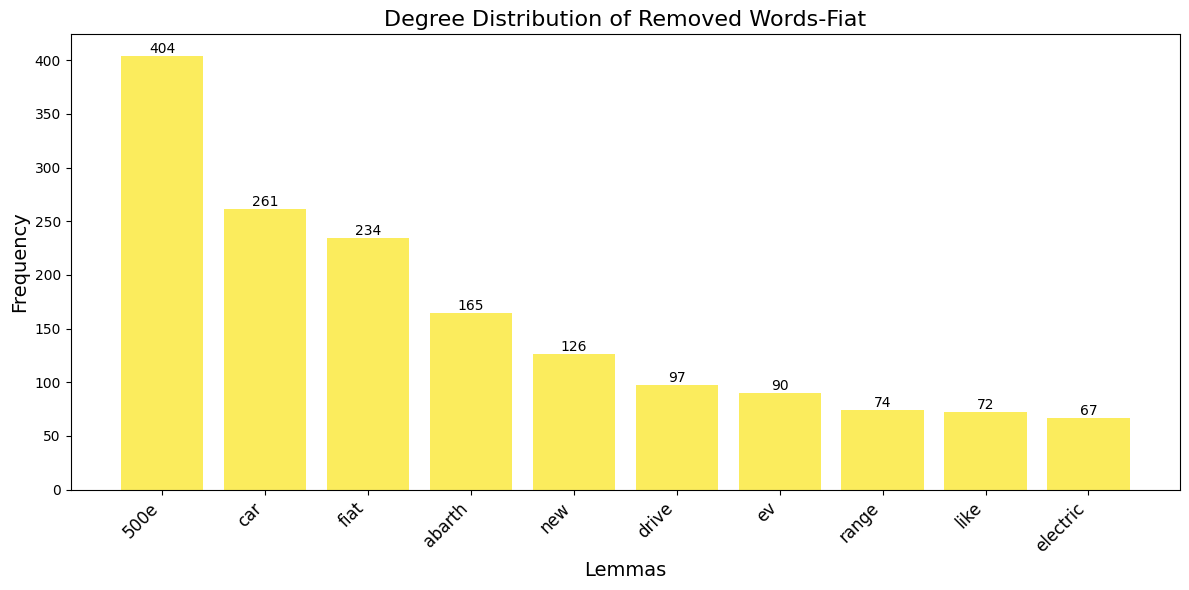

In [ ]:
# Visualize the degree distribution
plt.figure(figsize=(12, 6))
plt.bar(top_lemmas, top_frequencies, color='#FBEC5D')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Lemmas', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Degree Distribution of Removed Words-Fiat', fontsize=16)
plt.tight_layout()

# Add labels to the bars
for i, freq in enumerate(top_frequencies):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.show()

In [ ]:
# inspect the output of the LDA algorithm

# Print the topics with the words inside each topic
for k in range(lda.k):
    topic_words = [word for word, prob in lda.get_topic_words(k)]
    print(f"Topic #{k}: {', '.join(topic_words)}")

Topic #0: electric, ev, new, review, test, kona, drive, hot, hyundai, vehicle
Topic #1: range, come, life, scorpion, making, blog, city, enzari, real, similar
Topic #2: ev, year, month, cost, uk, drive, sell, california, little, buy
Topic #3: know, charger, want, don, need, charge, come, go, leaf, cheap
Topic #4: week, new, talk, chance, see, matt, steve, dacia, spring, autocar
Topic #5: like, battery, ll, look, get, good, issue, mile, charge, range
Topic #6: drive, mile, dealer, work, go, range, get, week, say, like
Topic #7: cool, abarthelectric, newabarth500e, newabarth500erange, teamabarth, trick, mph, fun, mean, charge
Topic #8: new, electric, power, design, contact, range, scorpion, catch, performance, let
Topic #9: love, premium, fun, open, variant, review, gain, warrant, new, autocar


In [ ]:
Theme_Abarth_E=["Electric Vehicle (EV) Reviews",
                "Urban Mobility and Comparisons",
                "EV Costs and Buying Trends",
                "Charging Concerns and Tips",
                "New Car Releases and Discussions",
                "Battery Performance and Range",
                "Driving Experiences and Range",
                "Abarth Electric Car Excitement",
                "Design and Performance of New EVs",
                "Enthusiasm for EV Models"]

In [ ]:
# Prepare topic coordinates
topics_coords = tmp.prepare_coords(lda)

# Sort topics_coords by topic in descending order
topics_coords = topics_coords.sort_values(by='size', ascending=False)

topics_coords

,x,y,topic,size,label
5,-94.664154,-1.348216,5,17.264881,5
2,22.903948,13.152630,2,17.063757,2
0,70.007248,-22.886568,0,13.397452,0
3,-22.534435,65.561836,3,13.084188,3
9,-2.866553,-54.585037,9,8.482541,9
6,-58.869915,-10.924808,6,8.453094,6
7,-62.025566,53.356857,7,6.391405,7
4,64.805099,54.348408,4,5.445173,4
8,29.116291,-33.200912,8,5.364560,8
1,83.479485,-72.702187,1,5.052958,1


In [ ]:
data1=topics_coords

In [ ]:
# Save the DataFrame as a CSV file in Google Drive
data1.to_csv("drive/My Drive/topics_coords_abarth-e.csv")

In [ ]:
tmp.report(lda, docs=corpus, height=500, width=250)

In [ ]:
# Get the topic distribution for each document
topic_distributions = [doc.get_topic_dist() for doc in lda.docs]

# Create a DataFrame to store the distribution of each topic for each document
topic_distribution_df = pd.DataFrame(topic_distributions)

# Add the original comments as a new column in the DataFrame
topic_distribution_df["Comments"] = df["comments"]

#topic_distribution_df.to_csv('/Users/lilypearl/Documents/FiatAbarth2_ARP/Scraping/New/topic_distribution_Abarth_e.csv')
csv_file_path = '/content/drive/My Drive/Colab Notebooks/Finaltopic_distribution_abarth_e.csv'
topic_distribution_df.to_csv(csv_file_path, index=False)


In [ ]:
# inspect the output of the LDA algorithm

# create a Rich's table to print the output of the spaCy's pipeline
console = Console()
# defin table properties
table = Table(
    show_header=True,
    header_style="cyan",
    title="[bold] [cyan] Word to topic probabilities (top 10 words)[/cyan]",
    width=150,
)
# add columns
table.add_column("Topic", justify="center", style="cyan", width=10)
table.add_column("W 1", width=12)
table.add_column("W 2", width=12)
table.add_column("W 3", width=12)
table.add_column("W 4", width=12)
table.add_column("W 5", width=12)
table.add_column("W 6", width=12)
table.add_column("W 7", width=12)
table.add_column("W 8", width=12)
table.add_column("W 9", width=12)
table.add_column("W 10", width=12)
# add rows
for k in range(lda.k):
    values = []
    for word, prob in lda.get_topic_words(k):
        values.append("{}\n({})\n".format(word, str(np.round(prob, 3))))
    table.add_row(
        str(k),
        values[0],
        values[1],
        values[2],
        values[3],
        values[4],
        values[5],
        values[6],
        values[7],
        values[8],
        values[9],
    )
# print the table
table

                                                       Word to topic probabilities (top 10 words)                                                     
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   Topic   ┃ W 1         ┃ W 2         ┃ W 3         ┃ W 4         ┃ W 5        ┃ W 6         ┃ W 7        ┃ W 8         ┃ W 9        ┃ W 10        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     0     │ electric    │ ev          │ new         │ review      │ test       │ kona        │ drive      │ hot         │ hyundai    │ vehicle     │
│           │ (0.09)      │ (0.078)     │ (0.056)     │ (0.045)     │ (0.037)    │ (0.026)     │ (0.024)    │ (0.024)     │ (0.024)    │ (0.024)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     1     │ range       │ come        │ life        │ scorpion    │ making     │ blog        │ city       │ enzari      │ real       │ similar     │
│           │ (0.114)     │ (0.093)     │ (0.077)     │ (0.062)     │ (0.062)    │ (0.062)     │ (0.057)    │ (0.057)     │ (0.041)    │ (0.036)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     2     │ ev          │ year        │ month       │ cost        │ uk         │ drive       │ sell       │ california  │ little     │ buy         │
│           │ (0.047)     │ (0.038)     │ (0.033)     │ (0.028)     │ (0.027)    │ (0.026)     │ (0.025)    │ (0.024)     │ (0.022)    │ (0.02)      │
│           │             │             │             │             │            │             │            │             │            │             │
│     3     │ know        │ charger     │ want        │ don         │ need       │ charge      │ come       │ go          │ leaf       │ cheap       │
│           │ (0.039)     │ (0.039)     │ (0.033)     │ (0.032)     │ (0.032)    │ (0.029)     │ (0.028)    │ (0.025)     │ (0.021)    │ (0.02)      │
│           │             │             │             │             │            │             │            │             │            │             │
│     4     │ week        │ new         │ talk        │ chance      │ see        │ matt        │ steve      │ dacia       │ spring     │ autocar     │
│           │ (0.173)     │ (0.089)     │ (0.089)     │ (0.089)     │ (0.085)    │ (0.081)     │ (0.081)    │ (0.081)     │ (0.081)    │ (0.069)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     5     │ like        │ battery     │ ll          │ look        │ get        │ good        │ issue      │ mile        │ charge     │ range       │
│           │ (0.04)      │ (0.036)     │ (0.031)     │ (0.025)     │ (0.025)    │ (0.025)     │ (0.023)    │ (0.023)     │ (0.02)     │ (0.019)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     6     │ drive       │ mile        │ dealer      │ work        │ go         │ range       │ get        │ week        │ say        │ like        │
│           │ (0.071)     │ (0.043)     │ (0.034)     │ (0.033)     │ (0.03)     │ (0.027)     │ (0.027)    │ (0.025)     │ (0.024)    │ (0.024)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     7     │ cool        │ abarthelec… │ newabarth5… │ newabarth5… │ teamabarth │ trick       │ mph        │ fun         │ mean       │ charge      │
│           │ (0.11)      │ (0.101)     │ (0.101)     │ (0.101)     │ (0.0

In [ ]:
# Select the rest of the data by using the ~ operator to negate the filter
Abarth = df[~df['comments'].str.contains('|'.join(Abarth_e_words))]

In [ ]:
Abarth

,comments,year,month,day
0,Anyone else notice this. \n \nNeither Zoe nor ...,2017,6,8
1,Skoda Superb Mk3 \n \n93.42 \n \nSkoda Yeti Mk...,2017,6,8
2,Are you saying that the ZOE topped the reliabi...,2017,6,8
3,They need a certain number off entrant's \nOr ...,2017,6,8
4,"Electric cars dominate Driver Power 2016, the ...",2017,6,8
...,...,...,...,...
3844,The Abarth is all stickered up ready for LeMan...,2023,6,5
3847,RT @collectingcars_: An involving performance ...,2023,6,9
3849,RT @collectingcars_: An involving performance ...,2023,6,9
3850,"An involving performance roadster, upgraded wi...",2023,6,9


In [ ]:
# Define a list of unwanted words
unwanted_words = ['rt', 'crypto', 'bitcoin', 'blockchain', 'patex', 'currency', 'patex_ecosystem','twitter','ve','tweet', 'retweet', '@', 'http']  # Add your unwanted words to this list

# Process data and store all lemmas
docs_tokens2, all_lemmas = [], []
for item in Abarth.loc[:, "comments"].astype(str).to_list():
    # Use regular expression to remove special characters, URLs, and non-alphanumeric characters
    item = re.sub(r'https?://\S+|www\.\S+', '', item)  # Remove URLs
    item = re.sub(r'[^\w\s]', ' ', item)  # Remove non-alphanumeric characters (except for spaces)
    item = re.sub(r'\s+', ' ', item).strip()  # Remove extra spaces and leading/trailing spaces
    item = re.sub(r'\n', ' ', item)  # Remove newline characters
    item = re.sub(r'\t', ' ', item)  # Remove tab characters
    item = re.sub(r'#', '', item)    # Remove pound sign

    # Convert all words to lowercase
    item = item.lower()

    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if (
            not token.is_stop
            and not token.is_punct
            and not token.like_num
            and not token.is_space
            and len(token.text) > 1  # Remove single characters and very short words
        )
    ]

    # Remove unwanted words
    tmp_tokens = [word for word in tmp_tokens if word not in unwanted_words]

    # Check if the document is not empty after removing unwanted words
    if tmp_tokens:
        docs_tokens2.append(tmp_tokens)
        all_lemmas.extend(tmp_tokens)

In [ ]:
# Tomotopy LDA estimation
corpus2 = tp.utils.Corpus()
for item in docs_tokens2:
    corpus2.add_doc(words=item)

lda2 = tp.LDAModel(min_df=5, rm_top=10, k=10, corpus=corpus2, seed=333)

# Train the model
for i in range(0, 1000, 10):
    lda2.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda2.ll_per_word))

<ipython-input-32-27a95cd8fbfb>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda2.train(10)


Iteration: 0	Log-likelihood: -7.884190875324915
Iteration: 10	Log-likelihood: -7.628657281507069
Iteration: 20	Log-likelihood: -7.5136879077169
Iteration: 30	Log-likelihood: -7.465166591644359
Iteration: 40	Log-likelihood: -7.425819751793265
Iteration: 50	Log-likelihood: -7.41163448597512
Iteration: 60	Log-likelihood: -7.384479899834561
Iteration: 70	Log-likelihood: -7.365433866888408
Iteration: 80	Log-likelihood: -7.347743733137157
Iteration: 90	Log-likelihood: -7.339989506062434
Iteration: 100	Log-likelihood: -7.317567654777226
Iteration: 110	Log-likelihood: -7.318678490188079
Iteration: 120	Log-likelihood: -7.306083507358312
Iteration: 130	Log-likelihood: -7.307272168635071
Iteration: 140	Log-likelihood: -7.303223143416745
Iteration: 150	Log-likelihood: -7.2917563148297875
Iteration: 160	Log-likelihood: -7.27730164843033
Iteration: 170	Log-likelihood: -7.289373665427758
Iteration: 180	Log-likelihood: -7.286021413185937
Iteration: 190	Log-likelihood: -7.281697615087965
Iteration: 200

In [ ]:
phi2 = tmp.get_phi(lda2)
phi2

topics,0,1,2,3,4,5,6,7,8,9
words,,,,,,,,,,
model,0.007544,0.063341,0.000003,0.000010,5.708897e-07,0.000001,0.000011,0.007190,0.000003,0.011090
tesla,0.003563,0.067692,0.000003,0.000010,5.708897e-07,0.000001,0.000011,0.000003,0.000003,0.014591
think,0.009639,0.000002,0.000003,0.000010,1.712726e-02,0.000001,0.000011,0.000003,0.000003,0.000003
like,0.011524,0.000002,0.000003,0.000010,1.541459e-02,0.000001,0.000011,0.005137,0.000003,0.000003
look,0.024093,0.000486,0.000003,0.000010,1.267432e-02,0.000001,0.000011,0.000003,0.000003,0.000003
...,...,...,...,...,...,...,...,...,...,...
stats_fee,0.000002,0.001211,0.000003,0.000010,5.708897e-07,0.000001,0.000011,0.000003,0.000003,0.000003
roc,0.000002,0.001211,0.000003,0.000010,5.708897e-07,0.000001,0.000011,0.000003,0.000003,0.000003
fiat500,0.000002,0.000002,0.000003,0.004801,5.708897e-07,0.000001,0.000011,0.000003,0.000003,0.000003


In [ ]:
# inspect the output of the LDA algorithm

# Print the topics with the words inside each topic
for k in range(lda2.k):
    topic_words = [word for word, prob in lda2.get_topic_words(k)]
    print(f"Topic #{k}: {', '.join(topic_words)}")

Topic #0: look, test, good, i3, fun, get, mini, like, seat, know
Topic #1: tesla, model, review, nissan, test, bmw, ioniq, leaf, audi, gt
Topic #2: see, change, sale, panda, part, petrol, year, diesel, miss, uk
Topic #3: forza, steal, update, blog, icon, summer, story, horizon, series, party
Topic #4: think, like, year, want, go, look, don, good, get, time
Topic #5: battery, charger, stop, time, brake, trip, use, start, day, need
Topic #6: classic, sport, club, auction, cool, bid, starting, hig, road, map
Topic #7: elmo, forum, month, peugeot, card, vehicle, vauxhall, list, corsa, group
Topic #8: renault, fault, dealer, update, app, customer, service, say, driver, record
Topic #9: vehicle, battery, price, evs, market, tesla, order, vw, production, high


In [ ]:
Theme_Abarth=["Enthusiastic Car Collecting and Racing",
              "Selling Vehicles Parts",
              "Exploring EV car",
              "Brake Systems and Speed Control",
              "Dealing with Dealerships",
              "Opinions and Preferences on Car Features",
              "Charging and Batteries",
              "Reviews and Tests of Kia and Hyundai",
              "Discussions and Similar Brands",
              "Delivery and Driver Experiences"]

In [ ]:
# Prepare topic coordinates
topics_coords2 = tmp.prepare_coords(lda2)

# Sort topics_coords by topic in descending order
topics_coords2 = topics_coords2.sort_values(by='size', ascending=False)

topics_coords2

,x,y,topic,size,label
4,106.448700,8.734710,4,29.998907,4
1,-28.159351,-66.435402,1,14.598981,1
5,91.163712,66.900818,5,10.732979,5
0,-23.969681,-1.330639,0,9.797280,0
2,-53.825695,58.756721,2,7.640993,2
7,107.622818,-69.478455,7,7.314276,7
9,32.314842,-95.359619,9,7.071628,9
8,152.898376,-31.687799,8,6.800539,8
6,24.548353,52.091827,6,3.127222,6
3,-109.233795,-12.051692,3,2.917197,3


In [ ]:
data=topics_coords2

In [ ]:
# Save the DataFrame as a CSV file in Google Drive
data.to_csv("drive/My Drive/topics_coords2_abarth.csv")

In [ ]:
tmp.report(lda2, docs=corpus2, height=500, width=250)

In [ ]:
# Get the topic distribution for each document
topic_distributions = [doc.get_topic_dist() for doc in lda2.docs]

# Create a DataFrame to store the distribution of each topic for each document
topic_distribution_df = pd.DataFrame(topic_distributions)

# Add the original comments as a new column in the DataFrame
topic_distribution_df["Comments"] = df["comments"]

#topic_distribution_df.to_csv('/Users/lilypearl/Documents/FiatAbarth2_ARP/Scraping/New/topic_distribution_Abarth.csv')
csv_file_path = '/content/drive/My Drive/Colab Notebooks/Finaltopic_distribution_ABARTH.csv'
topic_distribution_df.to_csv(csv_file_path, index=False)

